# Lab 2

In [52]:
import utils as ut
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import pandas as pd
from importlib import reload
import astropy.io.fits as fits

%matplotlib inline
pm = "\u00B1"  # plus-minus symbol for use in uncertainties

In [105]:
reload(ut)

<module 'utils' from '/Users/parkergeorge/UCSD/ASTR150/ASTRO150/utils.py'>

## 1. Read in Data

In [3]:
files = glob.glob('Lab2_data/*.csv')
# Swap Hydrogen to the front and Lamp to the back
files[0], files[5] = files[5], files[0]
files[2], files[5] = files[5], files[2]
print(files)

['Lab2_data/Hydrogen.csv', 'Lab2_data/Helium.csv', 'Lab2_data/Mercury.csv', 'Lab2_data/Neon.csv', 'Lab2_data/fluorescent.csv', 'Lab2_data/lamp.csv']


In [40]:
# 9 characters for lab2_data/ and -4 characters for .csv
name_slice = slice(10, -4)

In [4]:
all_data = ut.zeros(len(files))

for i, file in enumerate(files):
    # Read in csv file and skip the first 54 rows and the last line [End Of File]
    raw_data = pd.read_csv(file, engine='python',usecols=[0,1], skiprows=53, skipfooter=1)
    # Set the two columns of data to data type float
    raw_data['Pixel Number'] = raw_data['Pixel Number'].astype(float)
    raw_data['Measured Signal'] = raw_data['Measured Signal'].astype(float)

    all_data[i] = raw_data


all_data = np.array(all_data, dtype=np.float32)
all_data.shape

(6, 3648, 2)

## 2. Plot all Data Files

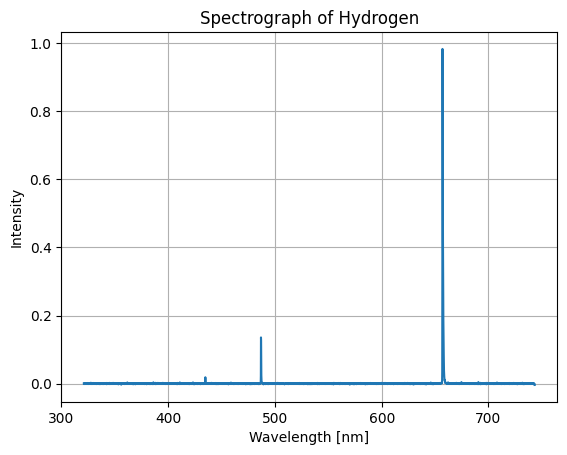

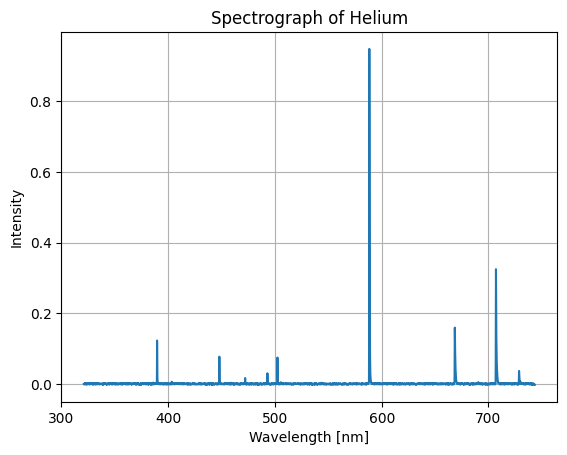

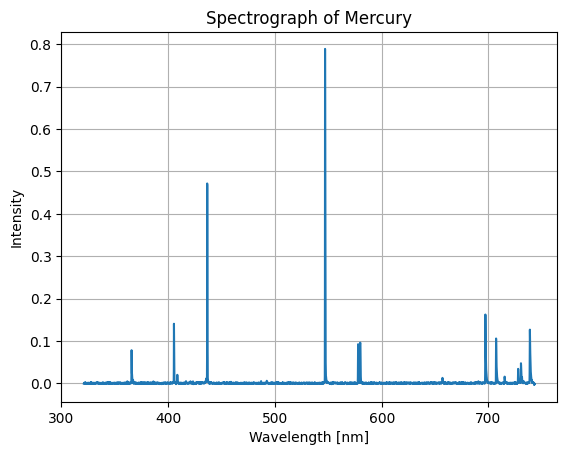

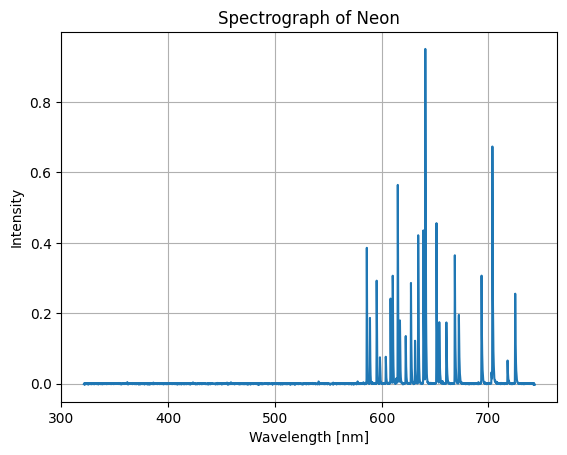

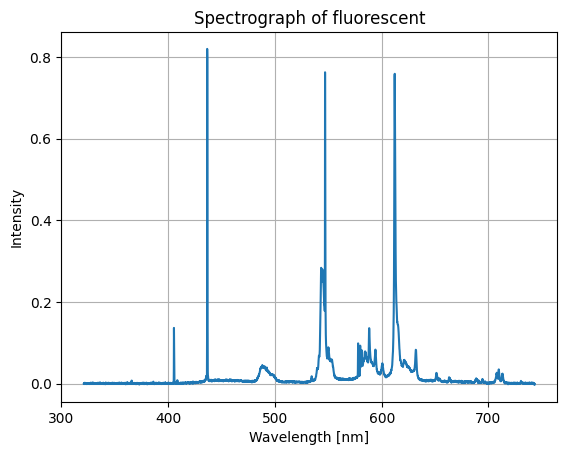

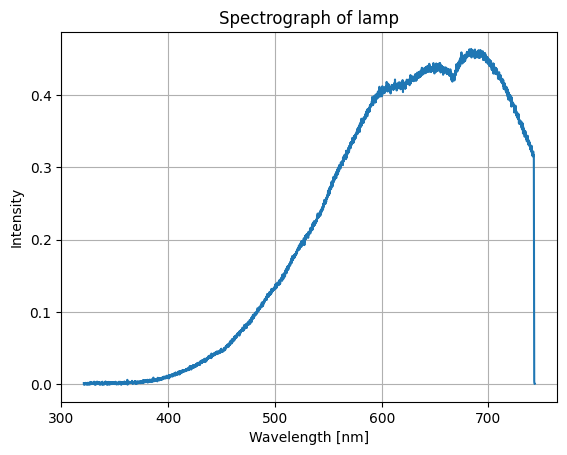

In [9]:
for i, data in enumerate(all_data):
    name = files[i][10:-4]
    x = data[:,0]
    y = data[:,1]
    plt.plot(x,y)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Intensity')
    plt.grid()
    plt.title(f'Spectrograph of {name}')
    plt.show()

## 3. Centroids and Pixel Numbers
$$
\left<x\right> = \frac{\sum x_i I_i}{\sum I_i}
$$

In [7]:
n = all_data.shape[0] - 1
all_pixel_nums = ut.zeros(n, dtype=np.float32)
all_centroids = ut.zeros(n, dtype=np.float32)

for i, data in enumerate(all_data[:-1]):
    all_pixel_nums[i], all_centroids[i] = ut.get_centroids(data[:,0], data[:,1], return_indices=True)

print(all_pixel_nums[0])
print(all_centroids[0])

[1025 1479 2923]
[434.78128 486.98587 657.2641 ]


## 4. Least Squares Fit
$$
y = mx+c
$$
$$
\begin{pmatrix}
\sum x_i^2 & \sum x_i \\[1mm]
\sum x_i & n
\end{pmatrix}
\begin{pmatrix}
m \\[1mm] c
\end{pmatrix}
= \begin{pmatrix}
\sum x_i y_i \\[1mm] \sum y_i
\end{pmatrix}
$$

In [18]:
slopes = ut.zeros(n, dtype=np.float32)
intercepts = ut.zeros(n, dtype=np.float32)

for i, pnum in enumerate(all_pixel_nums):
    slopes[i], intercepts[i] = ut.linear_least_squares(pnum, all_centroids[i])

print(slopes)
print(intercepts)

[np.float64(0.11738978926283394), np.float64(0.11744701313810757), np.float64(0.11707604280015294), np.float64(0.11915434442034467), np.float64(0.11724390244695715)]
[np.float64(313.9856212235336), np.float64(314.0682698334167), np.float64(315.62846854168265), np.float64(308.91466179491545), np.float64(315.5853252302527)]


### 4a. Error Propogation
$$
\sigma_m^2 = \frac{N\sigma^2}{N\sum x_i^2 - \left(\sum x_i\right)^2}
$$
$$
\sigma_c^2 = \frac{\sigma^2 \sum x_i^2}{N\sum x_i^2 - \left(\sum x_i\right)^2}
$$
$$
\sigma^2 = \frac{1}{N-2} \sum_i \left[y_i - (mx_i + c)\right]^2
$$

In [16]:
slope_errors = ut.zeros(n, dtype=np.float32)
intercept_errors = ut.zeros(n, dtype=np.float32)

for i, pnums in enumerate(all_pixel_nums):
    m = slopes[i]
    c = intercepts[i]
    centroids = all_centroids[i]
    N = len(centroids)

    # determine variance based on fit estimates
    tot = 0
    for j, xj in enumerate(pnums):
        tot += (centroids[j] - (m*xj + c)) ** 2
    variance = tot/(N-2)

    # calculate sums required for errors
    xsq_sum = ut.my_sum([xi**2 for xi in pnums])
    x_sum_sq = ut.my_sum([xi for xi in centroids]) ** 2

    # both uncertainties share a denominator, save computation
    denominator = N*xsq_sum - x_sum_sq

    # using formulas above
    slope_errors[i] = ((N*variance)/denominator)**.5
    intercept_errors[i] = ((variance*xsq_sum)/denominator)**.5

print(slope_errors)
print(intercept_errors)

[np.float64(0.0002393520108612582), np.float64(0.0001782603879320932), np.float64(0.0001314820476921579), np.float64(1.1326897430551008e-05), np.float64(0.00022612719959676865)]
[np.float64(0.47433576323123805), np.float64(0.4059531006729965), np.float64(0.3488566140962895), np.float64(0.031965287427926634), np.float64(0.5341023883408932)]


The slope error for Neon (index 3) is much lower than other data, most likely due to the large saturation of peaks in higher wavelengths. This result will cause some problems with weighing our measurements in the future.

### 4b. Weighted Means
$$
\sigma_{\bar{x}}^2 = \frac{1}{\sum \frac{1}{\sigma_i^2}}
$$
$$
\bar{x} = \sigma_{\bar{x}}^2 \sum \frac{x_i}{\sigma_i^2}
$$

In [19]:
slope_sig_sq_sum = ut.my_sum([1/(si**2) for si in slope_errors])
intercept_sig_sq_sum = ut.my_sum([1/(si**2) for si in intercept_errors])

slope_numerator = ut.my_sum([xi/(slope_errors[i]**2) for i, xi in enumerate(slopes)])
intercept_numerator = ut.my_sum([xi/(intercept_errors[i]**2) for i, xi in enumerate(intercepts)])

slope_error = 1 / slope_sig_sq_sum
slope = slope_numerator * slope_error

intercept_error = 1 / intercept_sig_sq_sum
intercept = intercept_numerator * intercept_error

print(f"m = {slope:.3g} {pm} {slope_error:.2g}")
print(f"c = {intercept:.3g} {pm} {intercept_error:.2g}")

m = 0.119 ± 1.3e-10
c = 309 ± 0.001


### 4c. Equally Weighted Means

Because of our extremely low slope error in Neon, we will go ahead and equally weigh everything and take the average for the best estimated result.

In [38]:
slope = ut.my_avg(slopes)
slope_error = ut.my_avg(slope_errors)
intercept = ut.my_avg(intercepts)
intercept_error = ut.my_avg(intercept_errors)
print(f"m = {slope:.4g} {pm} {slope_error:.2g}")
print(f"c = {intercept:.4g} {pm} {intercept_error:.2g}")

m = 0.1177 ± 0.00016
c = 313.6 ± 0.36


The wavelength calibration for our spectrometer is,
$$
\text{Wavelength} = m \cdot \left(\text{Pixel Number}\right) + c.
$$
Where,
$$
m = 0.1177 \pm 0.0002 \: \text{[nm/pixel]},
$$
and,
$$
c = 313.6 \pm 0.4 \: \text{[nm]}.
$$

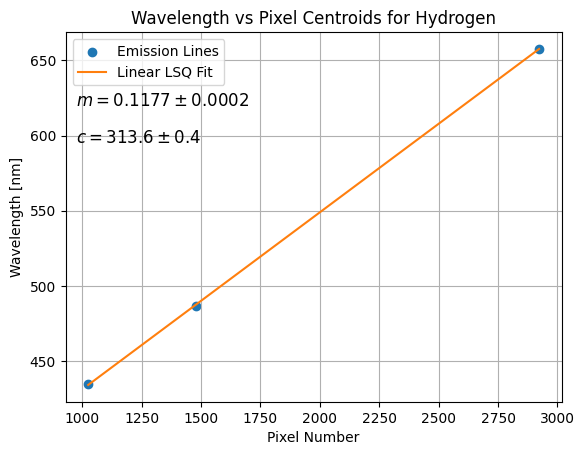

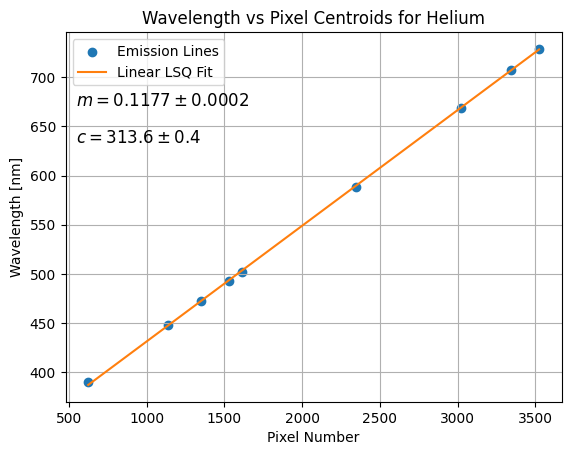

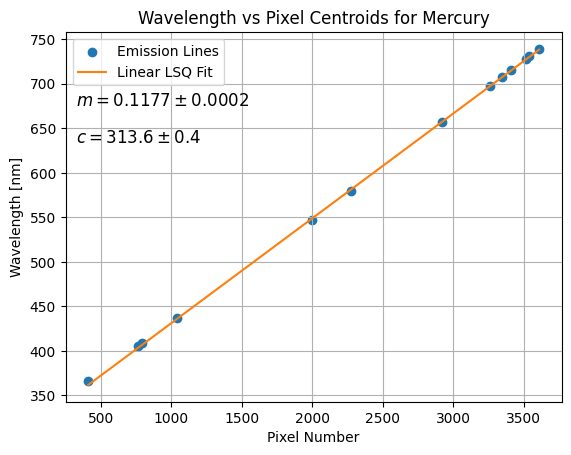

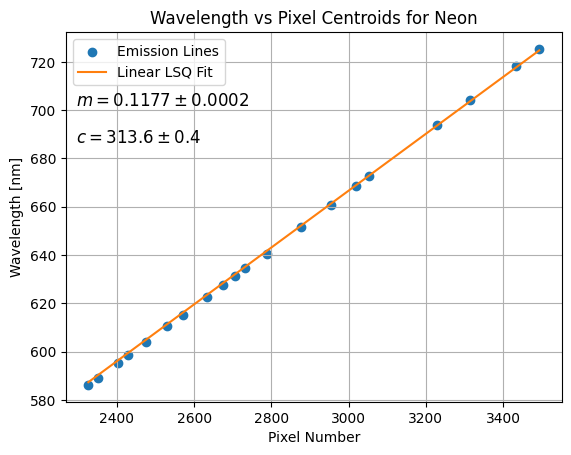

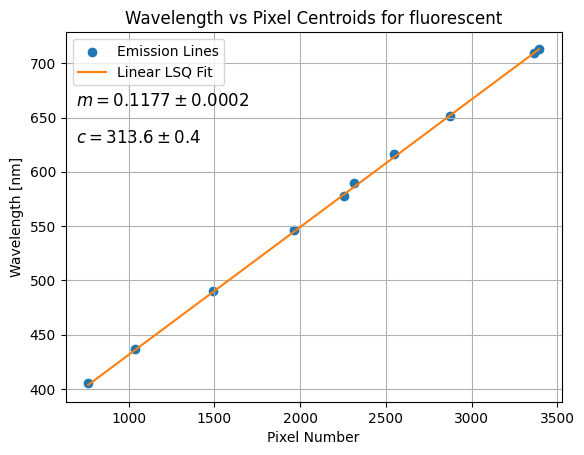

In [41]:
for idx in range(len(all_pixel_nums)):
    x = all_pixel_nums[idx]
    y = all_centroids[idx]
    plt.scatter(x, y, label='Emission Lines')
    plt.plot(x, slope*x + intercept, c='tab:orange', label='Linear LSQ Fit')
    plt.xlabel("Pixel Number")
    plt.ylabel("Wavelength [nm]")
    plt.title(f"Wavelength vs Pixel Centroids for {files[idx][name_slice]}")
    ax = plt.gca()
    plt.text(0.02, 0.8, r"$m=0.1177\pm0.0002$", fontsize=12, transform=ax.transAxes)
    plt.text(0.02, 0.7, r"$c=313.6\pm0.4$", fontsize=12, transform=ax.transAxes)
    plt.legend()
    plt.grid()
    plt.show()

## 5. KAST Data
### 5a. Read Data

In [79]:
frames = glob.glob('data-2013-10-26-shane-public/b1[0-6][0-9].fits')
ut.ascend_str(frames, (-7, -5))
arc = frames[0]
arc_frame = ut.get_data(arc)
bias = frames[1:11]
bias_frames = ut.get_data(bias)
dome_flats = frames[11:51]
dome_flat_frames = ut.get_data(dome_flats)
science = frames[51:61]
science_frames = ut.get_data(science)
arc, bias, dome_flats, science

('data-2013-10-26-shane-public/b100.fits',
 ['data-2013-10-26-shane-public/b101.fits',
  'data-2013-10-26-shane-public/b102.fits',
  'data-2013-10-26-shane-public/b103.fits',
  'data-2013-10-26-shane-public/b104.fits',
  'data-2013-10-26-shane-public/b105.fits',
  'data-2013-10-26-shane-public/b106.fits',
  'data-2013-10-26-shane-public/b107.fits',
  'data-2013-10-26-shane-public/b108.fits',
  'data-2013-10-26-shane-public/b109.fits',
  'data-2013-10-26-shane-public/b110.fits'],
 ['data-2013-10-26-shane-public/b111.fits',
  'data-2013-10-26-shane-public/b112.fits',
  'data-2013-10-26-shane-public/b113.fits',
  'data-2013-10-26-shane-public/b114.fits',
  'data-2013-10-26-shane-public/b115.fits',
  'data-2013-10-26-shane-public/b116.fits',
  'data-2013-10-26-shane-public/b117.fits',
  'data-2013-10-26-shane-public/b118.fits',
  'data-2013-10-26-shane-public/b119.fits',
  'data-2013-10-26-shane-public/b120.fits',
  'data-2013-10-26-shane-public/b121.fits',
  'data-2013-10-26-shane-public/

### 5b. Test Data

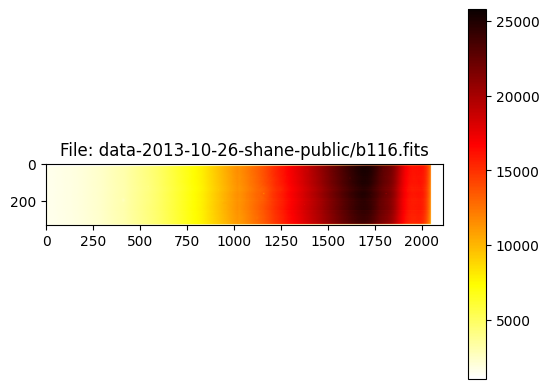

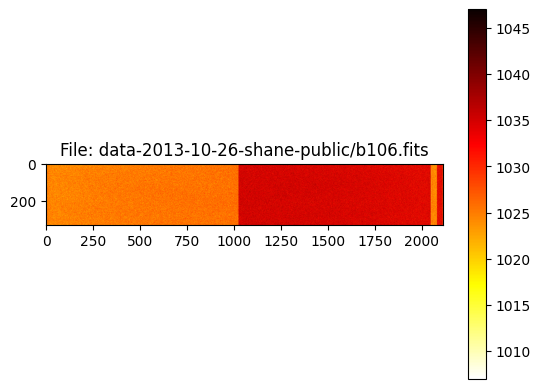

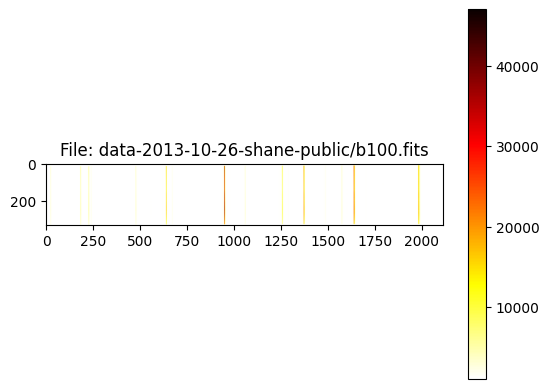

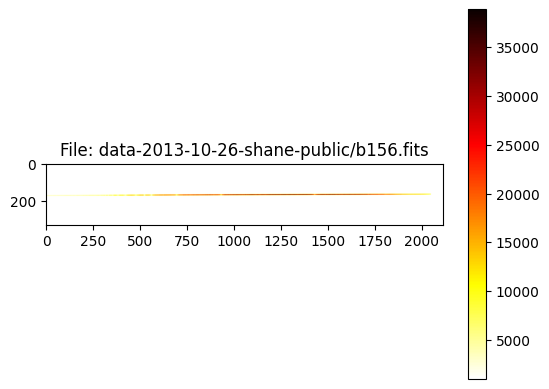

In [104]:
# Quick imshow frame test
test_dome = dome_flat_frames[20]
test_bias = bias_frames[5]
test_arc = arc_frame
test_science = science_frames[5]
plt.imshow(test_dome, cmap='hot_r')
plt.title(f'File: {dome_flats[5]}')
plt.colorbar()
plt.show()
plt.imshow(test_bias, cmap='hot_r')
plt.title(f'File: {bias[5]}')
plt.colorbar()
plt.show()
plt.imshow(test_arc, cmap='hot_r')
plt.title(f'File: {arc}')
plt.colorbar()
plt.show()
plt.imshow(test_science, cmap='hot_r')
plt.title(f'File: {science[5]}')
plt.colorbar()
plt.show()

In [63]:
# quick data display check
with fits.open(bias[0]) as hdu:
    hdr = hdu[0].header
    display(hdr)

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 2112 / NUMBER OF COLUMNS                              
NAXIS2  =                  325 / NUMBER OF ROWS                                 
CRVAL1U =                    0 / COLUMN ORIGIN                                  
CRVAL2U =                 1255 / ROW ORIGIN                                     
CDELT1U =                    1 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -1 / ROW CHANGE PER PIXEL                           
OBSNUM  =                  101 / OBSERVATION NUMBER                             
IDNUM   =                    2 / IMAGE ID                                       
UGEOM   =                    6 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

### 5c. Master Bias

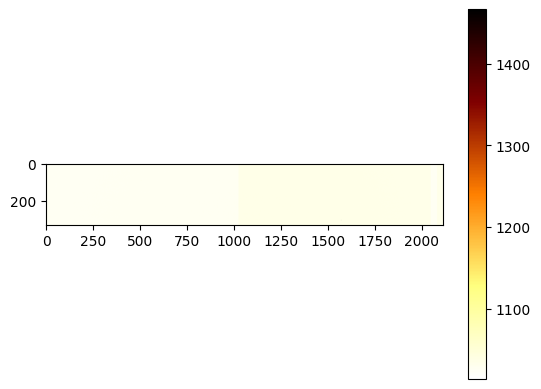

In [91]:
master_bias = ut.my_bias(bias)
plt.imshow(master_bias, cmap='hot_r')
plt.colorbar()
plt.show()

### 5d. Bias Subtraction

(10, 325, 2112)
(325, 2112)


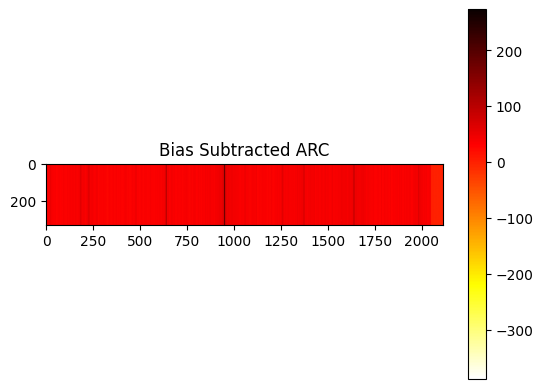

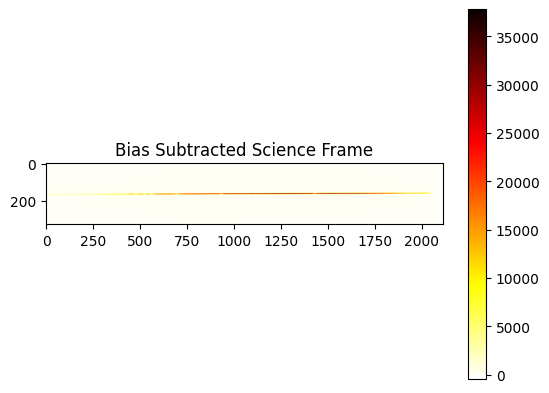

In [108]:
science_clean = ut.bias_sub(science_frames, master_bias)
print(np.shape(science_clean))
arc_clean = ut.bias_sub(arc_frame, master_bias, num_arrays=1)
print(np.shape(arc_clean))

plt.imshow(arc_clean, cmap='hot_r')
plt.title('Bias Subtracted ARC')
plt.colorbar()
plt.show()

plt.imshow(science_clean[5], cmap='hot_r')
plt.title('Bias Subtracted Science Frame')
plt.colorbar()
plt.show()

### 5e. Normalize Dome Flats

(40, 325, 2112)


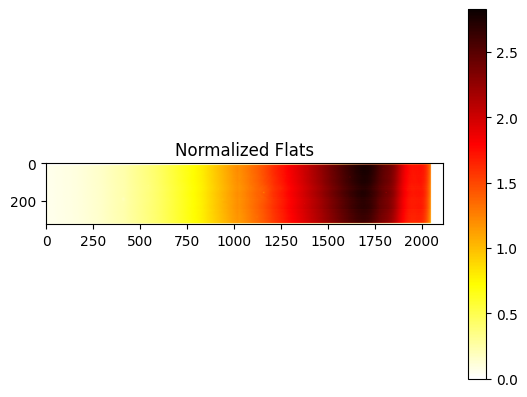

In [106]:
norm_flats = ut.normalize_flats(dome_flat_frames, master_bias)

print(np.shape(norm_flats))
plt.imshow(norm_flats[10], cmap='hot_r')
plt.title('Normalized Flats')
plt.colorbar()
plt.show()